In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# Belousov–Zhabotinsky reaction model

[Belousov–Zhabotinsky reaction](https://en.wikipedia.org/wiki/Belousov%E2%80%93Zhabotinsky_reaction) can be described by the following system:
 $$
 \begin{cases}
 \frac{dx(t)}{dt} = A + x^2(t)y(t) - (B+1)x(t),\;\; 0 \le t \le 20\\
 \frac{dy(t)}{dt} = Bx(t) - x^2(t)y(t)\\
 x(0) = 2 \;\;\;  y(0) = 3\\
 A = 1 \;\;\; B = 3\\
 \end{cases}
 $$
 
 The following methods are used in comparison:
 * Backwards differention
  $$
  \begin{cases}
  \frac{3u_{n+1} - 4u_n + u_{n-1}}{2\tau} = G(t_{n+1}, u_{n+1})\\
  u_0 = y(0)\\
  u_1 = u_0 + \tau G(\tau, u_1)
  \end{cases}
  $$
 * Euler explicit method
 $$
  \begin{cases}
  \frac{u_{n+1} - u_n}{\tau} = G(t_{n}, u_{n})\\
  u_0 = y(0)
  \end{cases}
 $$

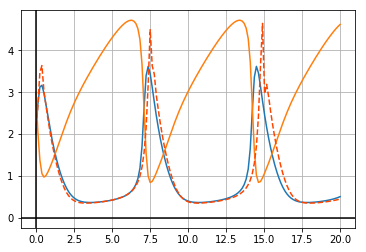

In [11]:
# Conditions given
A = 1
B = 3
u0 = [2, 3]
left = 0
right = 20
N = int(1.5e2)

x, y = sp.symbols('x y')
u = sp.Matrix([x, y])

G = sp.Matrix([A + x**2*y - (B+1)*x,
               B*x - x**2*y])
J = G.jacobian(u)

J_sc = sp.lambdify((x, y), J, [{'ImmutableMatrix': np.array}, "numpy"])
def J(u):
    return J_sc(u[0], u[1])

G_sc = sp.lambdify((x, y), G, [{'ImmutableMatrix': np.array}, "numpy"])
def G(u):
    return G_sc(u[0], u[1]).flatten()

def Newton_solve(u0, G, J, eps = 1e-14, max_it = 20):
    u = np.copy(u0)
    """
    Newton solver of equations system: G(u) = 0
    u -- initial approximation
    G -- left-hand side function
    J -- Jacobian of G
    eps -- precision
    max_it -- maximum number of iterations
    """
    for it in range(max_it):
        du = np.linalg.solve(J(u), -G(u))
        u += du
        if (np.linalg.norm(du) < eps): 
            break
    
    return u

ts, h = np.linspace(left, right, N, retstep=True) 
us = np.empty((N, 2))
us[0] = u0
us[1] = Newton_solve(us[0], lambda x: x - us[0] - h*G(x),
                            lambda x: np.eye(2) - h*J(x))

for n in range(1, N-1):
    # Backwards differential formula is used
    us[n+1] = Newton_solve(us[n], lambda x: 3*x - 4*us[n] + us[n-1] - 2*h*G(x),
                                 lambda x: 3*np.eye(2) - 2*h*J(x))

us_euler = np.empty((N, 2))
us_euler[0] = u0

for n in range(N-1):
    # euler explicit method
    us_euler[n+1] = us_euler[n] + h*G(us_euler[n])  

plt.plot(ts, us[:, 0])
plt.plot(ts, us[:, 1])
plt.plot(ts, us_euler[:, 0], linestyle='--', color='orangered')
plt.grid()
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()

# 1D Triangular well

Potential is given by:
$$
U(x) = 
\begin{cases}
+\infty, & x<0\\
x, & x \ge 0
\end{cases}
$$

Schrödinger equation can be written down as:

$$
-\frac{1}{2}\psi''(x) + x\psi(x) = E\psi(x)
$$

Boundary limits conditions:

$$
\psi(0) = 0\\
\lim_{x \to +\infty} \psi'(x) + \sqrt{2x-2E}\psi(x) = 0
$$

Can be reduced to following for simplification:
$$
\begin{cases}
-\frac{1}{2}\psi''(x) + x\psi(x) = E\psi(x)\\
\psi(0) = 0 \quad \quad \psi'(L) + \sqrt{2L-2E}\psi(L) = 0
\end{cases}
$$

What is the minimum possible $E$ necessary for the existence of non-trivial solution?

Let's remove the $\psi(0) = 0$ condition and replace it with $\psi(L)=1$. For every eigen-function $y_0(x) \;\; Cy_0(x)$ is also an eigen-function, thus we are not losing any solutions by this assumption. Let $y_0(0)=A(E)$, so we can consider $y_0(0)$ as function of $E$ for every $E$. Now we are interested in those $E$ which imply $y_0(0) = 0$, so we have left boundary condition fulfilled. 

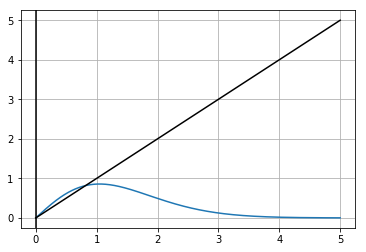

In [46]:
from scipy.linalg import solve_banded

N = 10**3
L = 5
xs, h = np.linspace(0, L, N, retstep=True)
E = 1.8557541037780465

ab = np.empty((3, N))
ab[0] = np.ones(N)
ab[1, -1] = 2*(1+h*(2*L-2*E)**0.5)
ab[1, 1:-1] = np.array([-2*(1-h**2*(E-m*h)) for m in range(1, N-1)], dtype=float)
ab[2] = np.ones(N)
ab[2, -2] = 2*(1-h**2*(E-(N-2)*h)) - 4

b = np.zeros(N)
b[-1] = 1

ys = solve_banded((0, 2), ab, b)
plt.plot(xs, ys/np.sqrt(sum(ys**2)*h))
plt.plot(xs, xs, color='k')
plt.axvline(x=0, color='k')
plt.grid()
plt.show()

Plot of the solution for lowest energy level. 

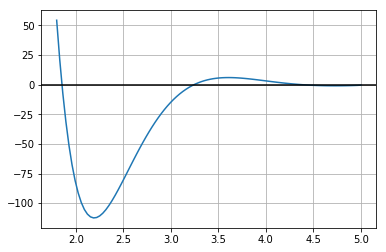

In [47]:
def left_value(E, L=5, N=10**3):
    xs, h = np.linspace(0, L, N, retstep=True)

    ab = np.empty((3, N))
    ab[0] = np.ones(N)
    ab[1, -1] = 2*(1+h*(2*L-2*E)**0.5)
    ab[1, 1:-1] = np.array([-2*(1-h**2*(E-m*h)) for m in range(1, N-1)], dtype=float)
    ab[2] = np.ones(N)
    ab[2, -2] = 2*(1-h**2*(E-(N-2)*h)) - 4

    b = np.zeros(N)
    b[-1] = 1

    ys = solve_banded((0, 2), ab, b)
    
    return ys[0]

nE = 100
l = 1.8
r = 5
Es = np.linspace(l, r, nE)
ls = [left_value(Es[n]) for n in range(nE)]

plt.plot(Es, ls)
plt.axhline(y=0, color='k')
plt.grid()
plt.show()

From the plot it follows that $E_0 \in [1.8, 2]$. Thus we only need to find the root of the $A(E)$ function.

In [49]:
from scipy.optimize import brentq

E0 = brentq(left_value, 1.8, 2)
print("Lowest energy level:", E0)

Lowest energy level: 1.8557541037780465
